<a href="https://colab.research.google.com/github/hemant-chapa23/ActivityDetector/blob/main/DL_Assignment_2_Draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import Libraries/Dataset

In [66]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.1 Import the required libraries

In [67]:
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools
import matplotlib.pyplot as plt

## 1.2 Checking GPU

In [68]:
!nvidia-smi

Tue Mar  7 20:42:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#@title Dataset configuration
base_path = '/content/drive/MyDrive/UCF-101'
images_path = '/content/drive/MyDrive/UCF-101/images/'
labels_path = '/content/drive/MyDrive/UCF-101-labels'
os.makedirs("/content/drive/MyDrive/UCF-101/train/")
os.makedirs("/content/drive/MyDrive/UCF-101/test/")


In [86]:
base_path

'/content/drive/MyDrive/UCF-101'

In [97]:
os.chdir(labels_path)
# print(os.getcwd())
train_vdos = []
for category in os.listdir(labels_path):
  if "train" in category:
    train_file = open(category, 'r')
    for line in train_file:
      fields = line.split()
      vdo = fields[0]
      label = fields[1]
      # print(f"Video: {vdo}, Label: {label}")
      train_vdos.append((vdo, label))
train_vdos

training = pd.DataFrame(train_vdos, columns = ["vdo", "label"])
training.head()

vdo label
0  ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c01.avi     1
1  ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c02.avi     1
2  ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c03.avi     1
3  ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c04.avi     1
4  ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c05.avi     1

(1, 5, 224, 224, 3)

In [ ]:
# load_videos(os.path.join(base_path,"ApplyLipstick/v_ApplyLipstick_g02_c02.avi"))

In [73]:
# labels = []
# videos_path = []
# for label in os.listdir(base_path):
#   labels.append(label)
#   videos_path.append(base_path+'/'+label+'/')
# labels.sort()
# videos_path.sort()

In [ ]:
# rec = cv2.VideoCapture("/content/drive/MyDrive/UCF-101/ApplyLipstick/v_ApplyLipstick_g02_c02.avi")

In [ ]:
# rec.get(cv2.CAP_PROP_FRAME_COUNT)

In [ ]:
# rec.set(cv2.CAP_PROP_POS_FRAMES, 8 * 10)

In [ ]:
# rec.read()[0]

In [ ]:
# pix = cv2.resize(rec.read()[1], (240,240))

In [ ]:
# from matplotlib import pyplot as plt
# plt.imshow(pix, interpolation='nearest')
# plt.show()


# 2. Data Processing

## 2.1 Converting the data into the correct format

---

The pre-trained model requires the input in 224 X 224 X 3 tensor.

TODO:
- Mention why the framing has to be done

In [133]:
def images_from_video(video_path):
  w = 224
  h = 224
  parts = 10
  frames = []
  vr = cv2.VideoCapture(video_path)

  frame_counts = int(vr.get(cv2.CAP_PROP_FRAME_COUNT))

  #Since extracting all the frames will be processing heavy, we create intervals on the frames that will be processed
  skip = max(int(frame_counts/parts), 1)
  # print("skip:",skip)
  # print("frame_counts:", frame_counts)

  for part in range(0,parts,2):
    vr.set(cv2.CAP_PROP_POS_FRAMES, part * skip)
    ret, frame = vr.read()

    if not ret:
      print(ret)
      break

    frame = cv2.resize(frame, (w, h))
    frame = frame/255
    frames.append(frame)

  vr.release()
  return frames


In [106]:
"""
This will take only the video path and not the entire directory
 """
def load_videos(video_path):
  images = []
  frames_list = images_from_video(video_path)
  images.append(frames_list)
  return np.array(images)

In [ ]:
# path=[]
# for label in labels:
#     path.append(images_path + label +"/")
# path[0]

In [142]:
training["vdo"][np.random.randint(0,500,20)]

71     ApplyEyeMakeup/v_ApplyEyeMakeup_g21_c01.avi
221                  Archery/v_Archery_g14_c02.avi
173      ApplyLipstick/v_ApplyLipstick_g23_c04.avi
235                  Archery/v_Archery_g16_c05.avi
404          BalanceBeam/v_BalanceBeam_g13_c01.avi
451          BalanceBeam/v_BalanceBeam_g23_c04.avi
308        BabyCrawling/v_BabyCrawling_g12_c03.avi
399          BalanceBeam/v_BalanceBeam_g11_c04.avi
466        BandMarching/v_BandMarching_g08_c06.avi
48     ApplyEyeMakeup/v_ApplyEyeMakeup_g16_c03.avi
400          BalanceBeam/v_BalanceBeam_g12_c01.avi
14     ApplyEyeMakeup/v_ApplyEyeMakeup_g10_c03.avi
405          BalanceBeam/v_BalanceBeam_g13_c02.avi
109      ApplyLipstick/v_ApplyLipstick_g10_c01.avi
248                  Archery/v_Archery_g19_c02.avi
375        BabyCrawling/v_BabyCrawling_g24_c04.avi
180      ApplyLipstick/v_ApplyLipstick_g25_c02.avi
376        BabyCrawling/v_BabyCrawling_g24_c05.avi
77     ApplyEyeMakeup/v_ApplyEyeMakeup_g22_c02.avi
294        BabyCrawling/v_BabyC

In [143]:
image_list = []
for vdo in training["vdo"][np.random.randint(0,500,20)]:
  print(vdo)
  img = load_videos(os.path.join(base_path,vdo))
  image_list.append(img)


BalanceBeam/v_BalanceBeam_g23_c02.avi
BalanceBeam/v_BalanceBeam_g19_c04.avi
BalanceBeam/v_BalanceBeam_g21_c02.avi
ApplyLipstick/v_ApplyLipstick_g12_c01.avi
ApplyEyeMakeup/v_ApplyEyeMakeup_g25_c03.avi
BandMarching/v_BandMarching_g11_c05.avi
BalanceBeam/v_BalanceBeam_g11_c02.avi
Archery/v_Archery_g15_c05.avi
BalanceBeam/v_BalanceBeam_g20_c03.avi
ApplyEyeMakeup/v_ApplyEyeMakeup_g20_c05.avi
BabyCrawling/v_BabyCrawling_g22_c04.avi
ApplyLipstick/v_ApplyLipstick_g10_c03.avi
BabyCrawling/v_BabyCrawling_g12_c06.avi
BalanceBeam/v_BalanceBeam_g25_c01.avi
BalanceBeam/v_BalanceBeam_g17_c04.avi
ApplyEyeMakeup/v_ApplyEyeMakeup_g09_c07.avi
Archery/v_Archery_g09_c02.avi
ApplyEyeMakeup/v_ApplyEyeMakeup_g12_c03.avi
BabyCrawling/v_BabyCrawling_g23_c02.avi
ApplyLipstick/v_ApplyLipstick_g24_c05.avi


1 1 1


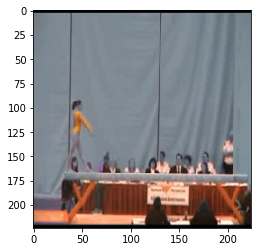

1 1 2


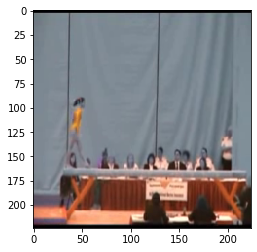

1 1 3


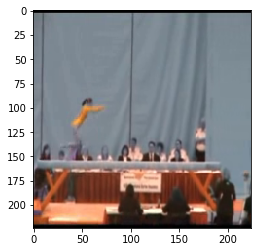

1 1 4


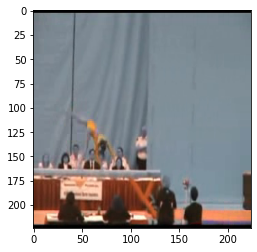

1 1 5


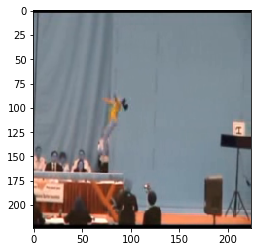

2 2 6


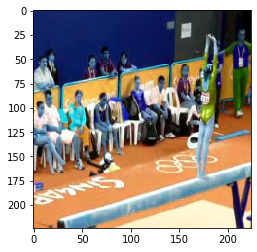

2 2 7


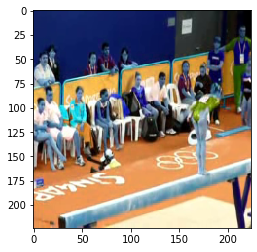

2 2 8


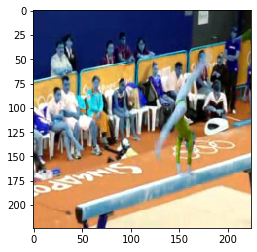

2 2 9


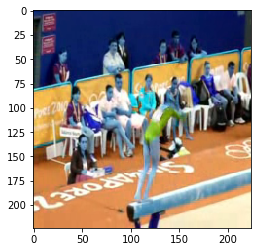

2 2 10


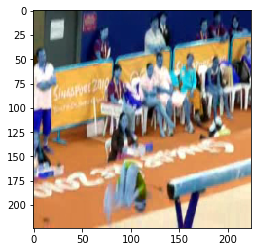

3 3 11


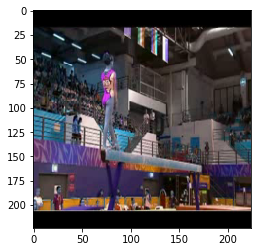

3 3 12


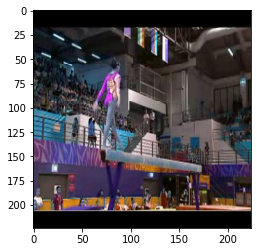

3 3 13


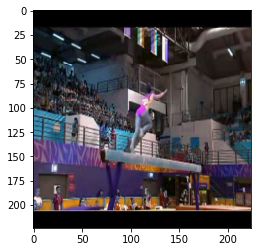

3 3 14


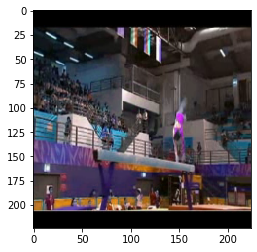

3 3 15


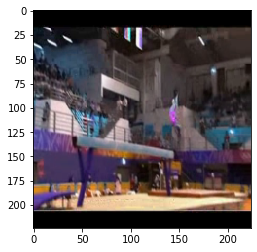

4 4 16


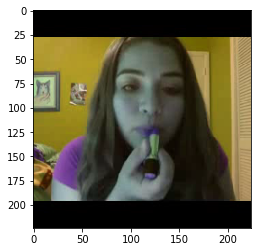

4 4 17


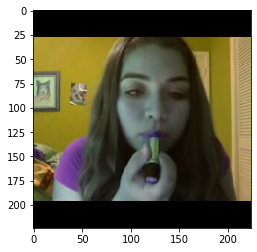

4 4 18


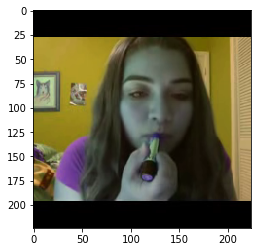

4 4 19


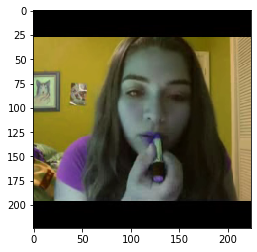

4 4 20


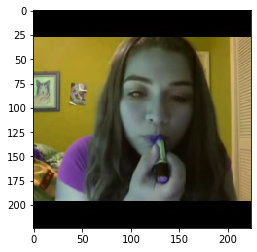

5 5 21


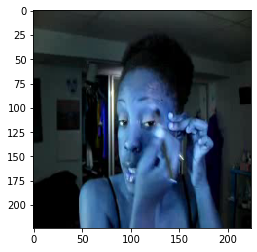

5 5 22


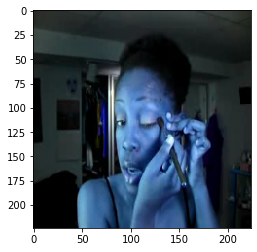

5 5 23


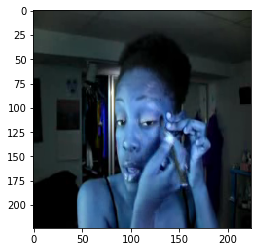

5 5 24


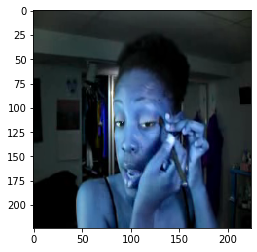

5 5 25


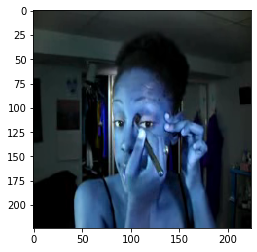

6 6 26


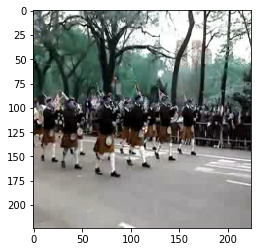

6 6 27


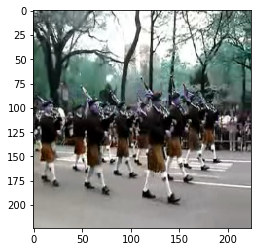

6 6 28


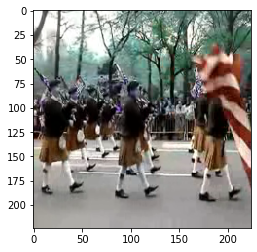

6 6 29


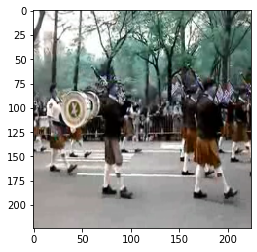

6 6 30


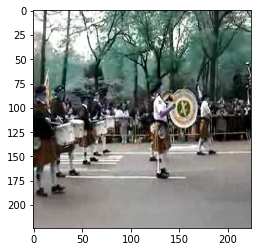

7 7 31


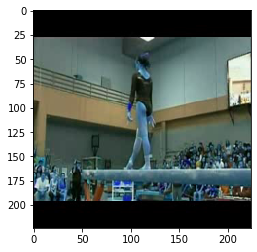

7 7 32


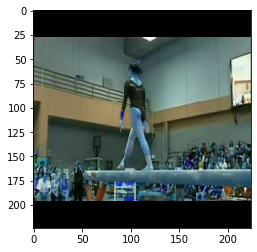

7 7 33


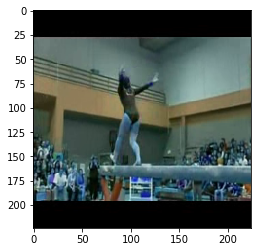

7 7 34


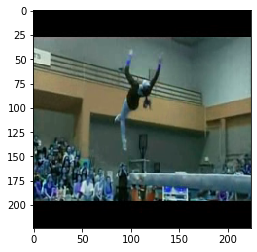

7 7 35


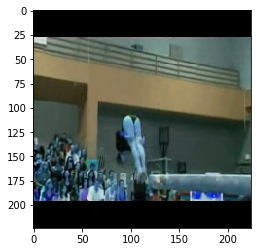

8 8 36


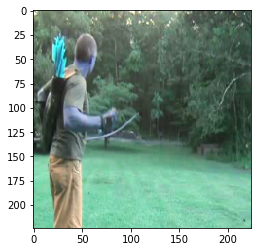

8 8 37


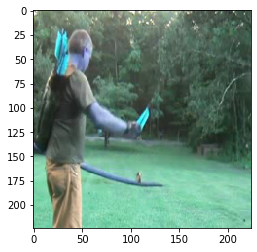

8 8 38


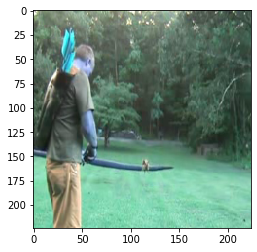

8 8 39


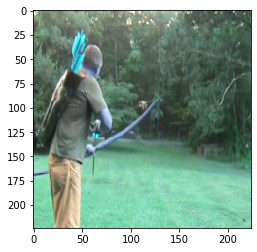

8 8 40


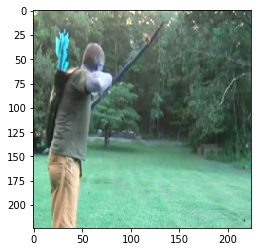

9 9 41


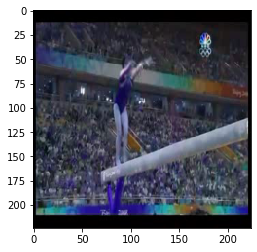

9 9 42


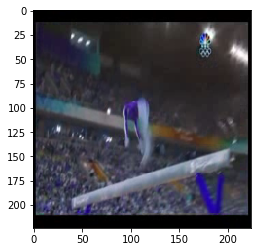

9 9 43


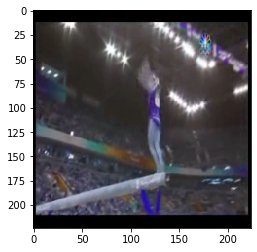

9 9 44


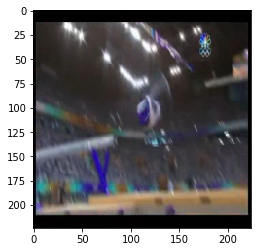

9 9 45


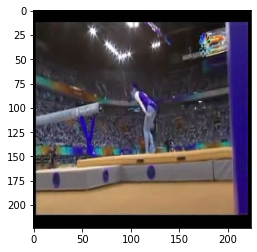

10 10 46


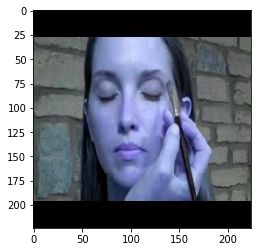

10 10 47


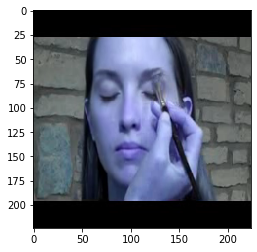

10 10 48


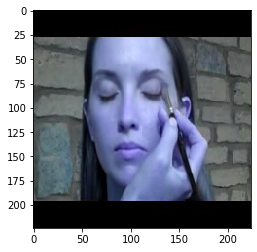

10 10 49


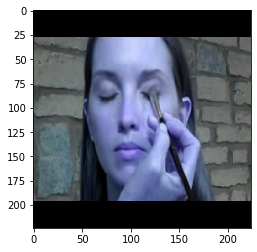

10 10 50


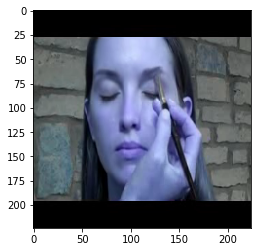

11 11 51


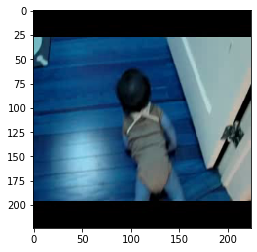

11 11 52


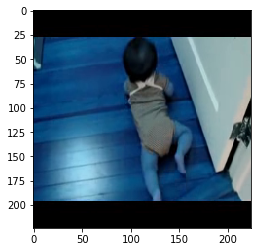

11 11 53


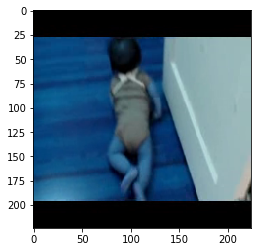

11 11 54


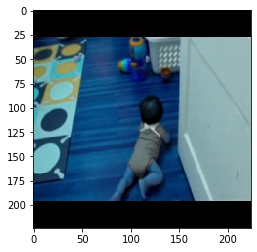

11 11 55


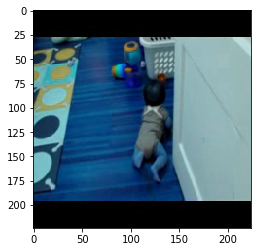

12 12 56


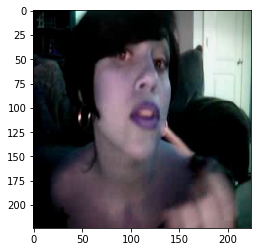

12 12 57


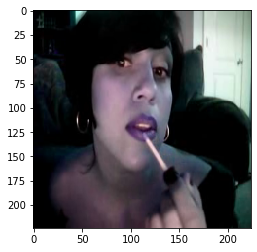

12 12 58


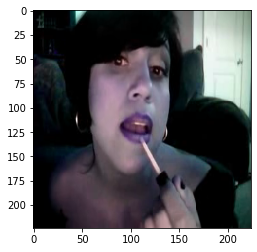

12 12 59


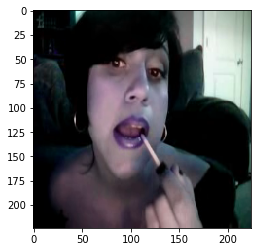

12 12 60


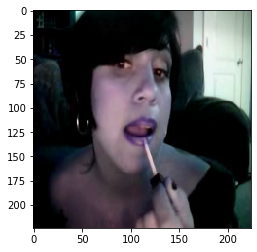

13 13 61


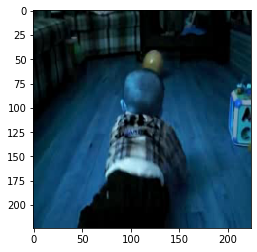

13 13 62


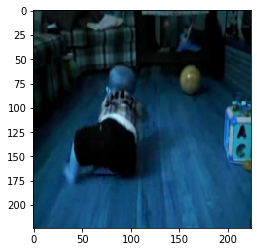

13 13 63


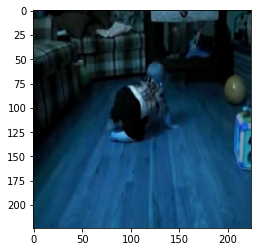

13 13 64


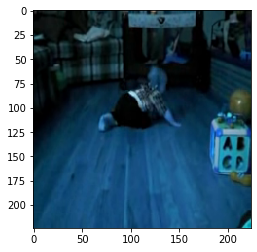

13 13 65


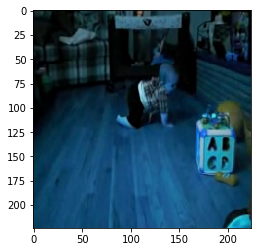

14 14 66


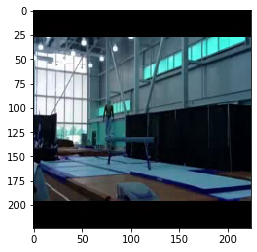

14 14 67


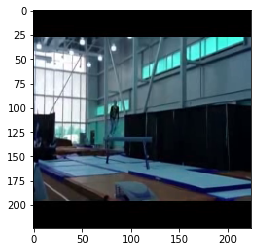

14 14 68


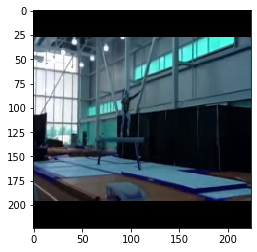

14 14 69


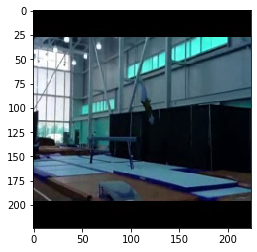

14 14 70


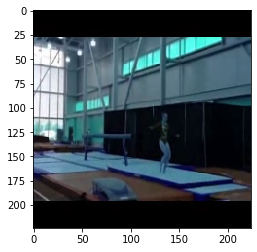

15 15 71


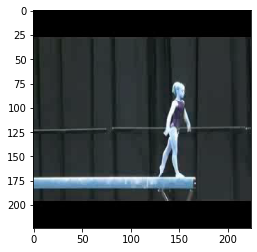

15 15 72


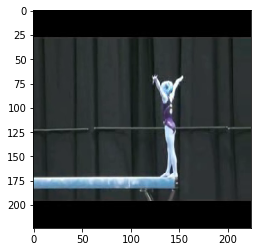

15 15 73


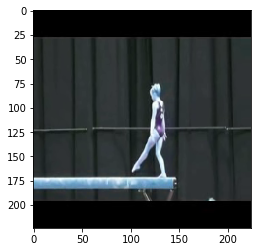

15 15 74


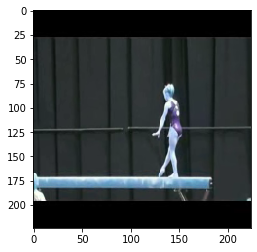

15 15 75


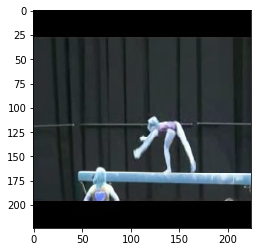

16 16 76


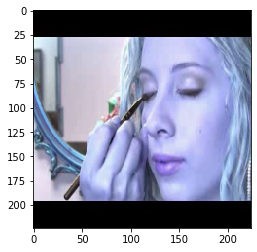

16 16 77


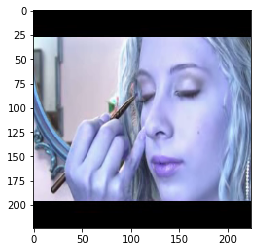

16 16 78


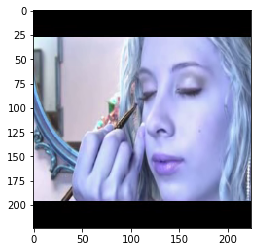

16 16 79


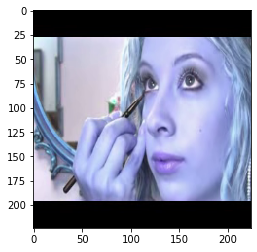

16 16 80


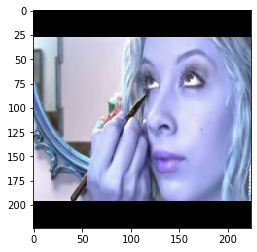

17 17 81


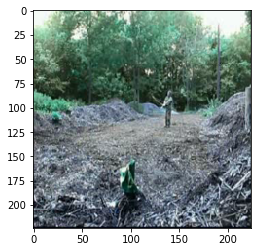

17 17 82


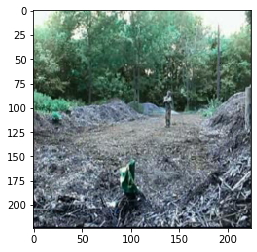

17 17 83


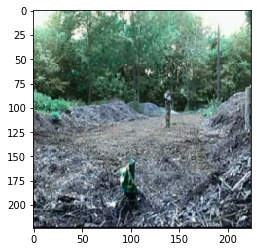

17 17 84


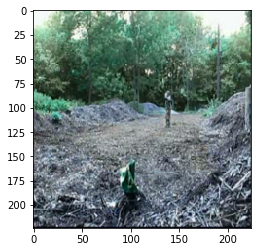

17 17 85


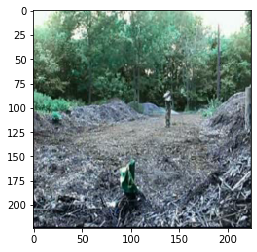

18 18 86


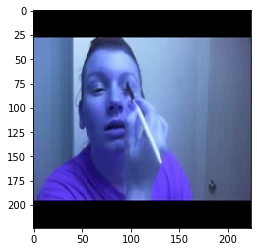

18 18 87


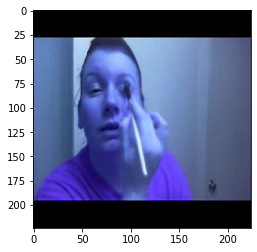

18 18 88


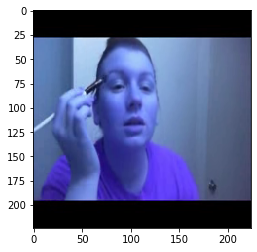

18 18 89


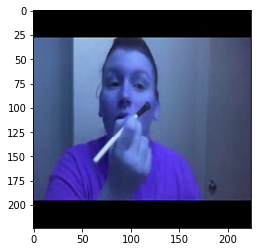

18 18 90


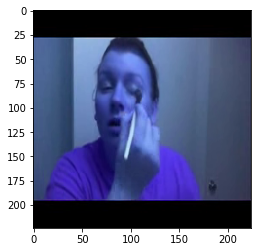

19 19 91


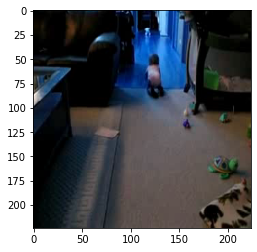

19 19 92


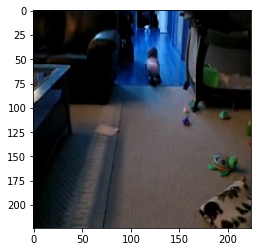

19 19 93


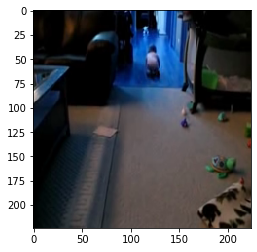

19 19 94


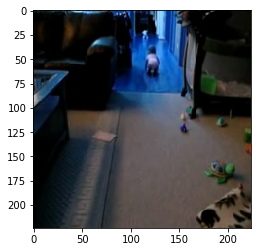

19 19 95


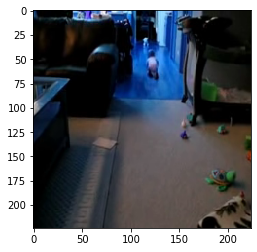

20 20 96


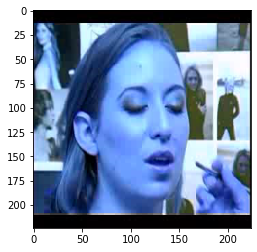

20 20 97


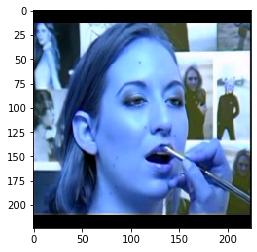

20 20 98


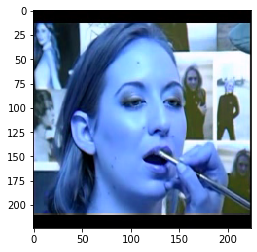

20 20 99


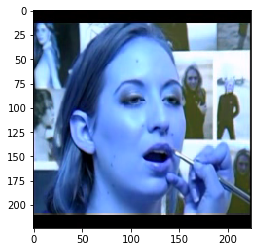

20 20 100


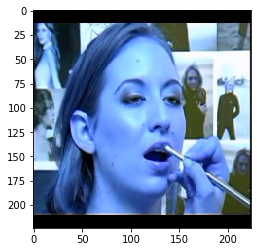

In [144]:
i = 0
j = 0
k = 0
for images in image_list:
  i+=1
  for image in images:
    j+=1
    for frm in image:
      k+=1
      print(i,j,k)
      plt.imshow(frm, interpolation = 'nearest')
      plt.show()

In [101]:
"""
def load_videos(data_dir):
  label_index = 0
  labels = []
  images = []

  for folder in data_dir:
    # print("folder: ", folder )
    for video in tqdm(os.listdir(folder)):
      
      video_path = os.path.join(folder, video)
      # print("video_path:", video_path)
      frames_list = images_from_video(video_path)
      print(f"Video: {video}, Frames: {len(frames_list)}")
      images.append(frames_list)
      labels.append(label_index)
    label_index += 1

  return np.array(images), np.array(labels, dtype = 'int8')
"""

'\ndef load_videos(data_dir):\n  label_index = 0\n  labels = []\n  images = []\n\n  for folder in data_dir:\n    # print("folder: ", folder )\n    for video in tqdm(os.listdir(folder)):\n      \n      video_path = os.path.join(folder, video)\n      # print("video_path:", video_path)\n      frames_list = images_from_video(video_path)\n      print(f"Video: {video}, Frames: {len(frames_list)}")\n      images.append(frames_list)\n      labels.append(label_index)\n    label_index += 1\n\n  return np.array(images), np.array(labels, dtype = \'int8\')\n'

In [ ]:
# images, labels = load_videos(videos_path[1:2])

In [54]:
os.path.join(base_path,'/train/')

'/train/'

In [55]:
base_path

'/content/drive/MyDrive/UCF-101'